# Adversarial ML (defense)

In [1]:
# Imports

from io import BytesIO

import requests
import json
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from matplotlib import pyplot as plt

## 1. Get images and ground truth labels (labels predicted by API, considered as GT)

GT labels = predicted by API labels: tensor([3, 2, 3, 1, 1, 0, 8, 5, 8, 1])


(torch.Size([300]), torch.Size([300, 28, 28]))

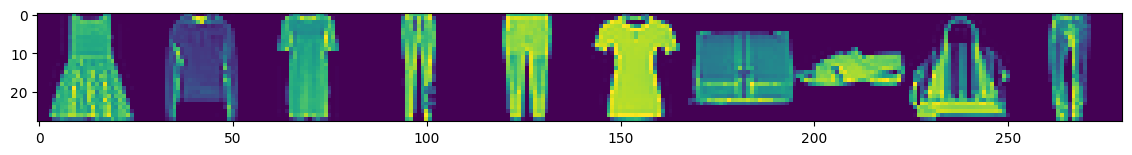

In [2]:
HOST = 'http://127.0.0.1:8000'
POST_HEADERS = {'Content-Type': 'application/octet-stream'}


def GET(path, **params):
    url = f"{HOST}/{path}"
    return requests.get(url, params=params)


def POST(path, data_bytes):
    url = f"{HOST}/{path}"
    return requests.post(url, data=data_bytes, headers=POST_HEADERS)


def activate(task, token):
    return GET("api/activate", task=task, token=token)


def handle_errors(response):
    if response.status_code != 200:
        print(response.content)
        raise RuntimeError(f"Unexpected HTTP status: {response.status_code}")


def evasion_get_challenge():
    response = GET("api/evasion/get_challenge")
    handle_errors(response)
    challenge = json.loads(response.content.decode("utf-8"))
    images = torch.tensor(np.array(challenge["images"], dtype=np.float32))
    targets = torch.tensor(challenge["targets"], dtype=torch.long)
    return images, targets


def evasion_solve_challenge(x_adv):
    data = x_adv.astype(np.float32).tobytes()
    response = POST("api/evasion/solve_challenge", data)
    handle_errors(response)
    token = response.text
    print(f"{token=}")
    return token


def stealing_get_challenge():
    response = GET("api/stealing/get_challenge")
    handle_errors(response)
    challenge = json.loads(response.content.decode("utf-8"))
    images = torch.tensor(np.array(challenge["images"], dtype=np.float32))
    return images


def stealing_solve_challenge(scores):
    data = scores.astype(np.float32).tobytes()
    response = POST("api/stealing/solve_challenge", data)
    handle_errors(response)
    token = response.text
    print(f"{token=}")
    return token


def predict(images):
    if not isinstance(images, np.ndarray) or images.dtype != np.float32:
        raise ValueError("Wrong format for images. Expected nd.array(dtype=np.float32)")
    response = POST("api/predict", images.tobytes())
    return response

# Get images
images, _ = evasion_get_challenge()
images_npy = images.numpy()
# Get labels
resp = predict(images_npy)
softmaxs = json.loads(resp.content.decode())['data']
softmaxs = np.array(softmaxs)
labels = torch.tensor(np.argmax(softmaxs, axis=1))

# Plot images
plt.figure(figsize=(14,14))
_ = plt.imshow(images_npy.transpose(0,2,1).transpose(2,0,1).reshape(28, -1)[:,:10*28])
# Print labels
print(f'GT labels = predicted by API labels: {labels[:10]}')
labels.shape, images.shape

## 2. Model training

### Adv example function

In [112]:
# Compute adversarial example
def adv(
    adv_inputs, 
    normal_inputs,
    optimizer, 
    model, 
    loss_fn, 
    MAX_ITER_FGSM,
    EPS, 
    ETA,
):
    """
    Computes an adv example using I-FGSM
    """
    iter_count = 0
    max_loss, adv_inputs_max = 0, adv_inputs.clone().detach()
    # Generate adversarial examples using I-FGSM
    while iter_count < MAX_ITER_FGSM:
        adv_inputs.requires_grad = True
        optimizer.zero_grad()
        logits = model(adv_inputs)
        loss = loss_fn(logits, targets)
        if loss > max_loss:
            max_loss = loss
            adv_inputs_max = adv_inputs.clone()
        loss.backward()
        grad = adv_inputs.grad.data
        sign_grad = grad.sign()
        perturbed_inputs = adv_inputs + ETA * sign_grad
        # Calculate the infinity norm of the perturbation
        perturbation = perturbed_inputs - normal_inputs
        inf_norm = torch.max(torch.abs(perturbation)).item()
        # Check if the infinity norm exceeds EPS
        if inf_norm > EPS:
            break
        # Clip the perturbed inputs to ensure they are within the valid range [0, 255]
        adv_inputs = torch.clamp(perturbed_inputs, 0, 255).detach()
        iter_count += 1
    if iter_count == MAX_ITER_FGSM:
        print('norm not exceeded')
    return adv_inputs_max

### EPS = 20

In [125]:
%%time


### HYPERPARAMS ####
MINI_BATCH_SIZE = 16
EPOCHS = 200
LR = 0.0005
EPS = 20  # Total epsilon for I-FGSM
ETA = 2  # Step for each iteration
MAX_ITER_FGSM = 20  # Maximum number of iterations for I-FGSM
####################


# Get initialized mode
from core.models import FashionNN
model20 = FashionNN()
model20.train()

# Dataloader
dataset = TensorDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)

# Optim & loss function
optimizer = optim.SGD(model20.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Train
for epoch in range(EPOCHS):
    for i, (normal_inputs, targets) in enumerate(dataloader):
        normal_inputs.requires_grad = True
        adv_inputs = adv(normal_inputs.clone().detach(), 
            normal_inputs.clone().detach(),
            optimizer, 
            model20, 
            loss_fn, 
            MAX_ITER_FGSM,
            EPS, 
            ETA,
        )
        if epoch == 199 and i == 15:
            model20.eval()
            normal_labels = torch.argmax(model20(normal_inputs), 1)
            adv_labels = torch.argmax(model20(adv_inputs), 1)
            print(f'{      targets = }')
            print(f'{normal_labels = }')
            print(f'{   adv_labels = }')
            model20.train()
        for inputs in [normal_inputs, adv_inputs]:
            optimizer.zero_grad()
            logits = model20(inputs)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()

# Predict
model20.eval()
prediction = torch.argmax(model20(images), axis=1)

print(f'Prediction accuracy: {int((labels == prediction).sum())/300*100 :.2f} %\n')

      targets = tensor([1, 1, 9, 7, 6, 7, 5, 9, 5, 0, 5, 0, 0, 0, 7, 2])
normal_labels = tensor([1, 1, 9, 7, 6, 7, 5, 9, 5, 0, 5, 0, 0, 0, 7, 2])
   adv_labels = tensor([1, 1, 7, 7, 2, 7, 5, 9, 5, 0, 5, 0, 0, 0, 7, 2])
Prediction accuracy: 100.00 %

CPU times: user 13min 32s, sys: 888 ms, total: 13min 33s
Wall time: 1min 21s


### EPS = 40

In [132]:
%%time


### HYPERPARAMS ####
MINI_BATCH_SIZE = 16
EPOCHS = 200
LR = 0.0005
EPS = 40  # Total epsilon for I-FGSM
ETA = 4  # Step for each iteration
MAX_ITER_FGSM = 20  # Maximum number of iterations for I-FGSM
####################


# Get initialized mode
from core.models import FashionNN
model40 = FashionNN()
model40.train()

# Dataloader
dataset = TensorDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)

# Optim & loss function
optimizer = optim.SGD(model40.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Train
for epoch in range(EPOCHS):
    for i, (normal_inputs, targets) in enumerate(dataloader):
        normal_inputs.requires_grad = True
        adv_inputs = adv(normal_inputs.clone().detach(), 
            normal_inputs.clone().detach(),
            optimizer, 
            model40, 
            loss_fn, 
            MAX_ITER_FGSM,
            EPS, 
            ETA,
        )
        if epoch == 199 and i == 15:
            model40.eval()
            normal_labels = torch.argmax(model40(normal_inputs), 1)
            adv_labels = torch.argmax(model40(adv_inputs), 1)
            print(f'{      targets = }')
            print(f'{normal_labels = }')
            print(f'{   adv_labels = }')
            model40.train()
        for inputs in [normal_inputs, adv_inputs]:
            optimizer.zero_grad()
            logits = model40(inputs)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()

# Predict
model40.eval()
prediction = torch.argmax(model40(images), axis=1)

print(f'Prediction accuracy: {int((labels == prediction).sum())/300*100 :.2f} %\n')

      targets = tensor([5, 5, 2, 7, 3, 2, 5, 4, 6, 5, 6, 0, 0, 3, 5, 2])
normal_labels = tensor([5, 5, 4, 7, 3, 4, 5, 4, 4, 5, 4, 0, 0, 3, 5, 2])
   adv_labels = tensor([7, 9, 4, 7, 1, 8, 7, 3, 4, 7, 4, 1, 0, 2, 9, 4])
Prediction accuracy: 86.33 %

CPU times: user 13min 4s, sys: 788 ms, total: 13min 5s
Wall time: 1min 18s


### EPS = 10

In [131]:
%%time


### HYPERPARAMS ####
MINI_BATCH_SIZE = 16
EPOCHS = 200
LR = 0.0005
EPS = 10  # Total epsilon for I-FGSM
ETA = 1  # Step for each iteration
MAX_ITER_FGSM = 20  # Maximum number of iterations for I-FGSM
####################


# Get initialized mode
from core.models import FashionNN
model10 = FashionNN()
model10.train()

# Dataloader
dataset = TensorDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)

# Optim & loss function
optimizer = optim.SGD(model10.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Train
for epoch in range(EPOCHS):
    for i, (normal_inputs, targets) in enumerate(dataloader):
        normal_inputs.requires_grad = True
        adv_inputs = adv(normal_inputs.clone().detach(), 
            normal_inputs.clone().detach(),
            optimizer, 
            model10, 
            loss_fn, 
            MAX_ITER_FGSM,
            EPS, 
            ETA,
        )
        if epoch == 199 and i == 15:
            model10.eval()
            normal_labels = torch.argmax(model10(normal_inputs), 1)
            adv_labels = torch.argmax(model10(adv_inputs), 1)
            print(f'{      targets = }')
            print(f'{normal_labels = }')
            print(f'{   adv_labels = }')
            model10.train()
        for inputs in [normal_inputs, adv_inputs]:
            optimizer.zero_grad()
            logits = model10(inputs)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()

# Predict
model10.eval()
prediction = torch.argmax(model10(images), axis=1)

print(f'Prediction accuracy: {int((labels == prediction).sum())/300*100 :.2f} %\n')

      targets = tensor([2, 7, 1, 5, 7, 5, 3, 5, 8, 1, 7, 0, 2, 8, 4, 3])
normal_labels = tensor([2, 7, 1, 5, 7, 5, 3, 5, 8, 1, 7, 0, 2, 8, 4, 3])
   adv_labels = tensor([2, 7, 1, 5, 7, 5, 3, 5, 8, 1, 7, 0, 2, 8, 4, 3])
Prediction accuracy: 100.00 %

CPU times: user 13min 59s, sys: 900 ms, total: 13min 59s
Wall time: 1min 24s


### EPS = 1

In [123]:
%%time


### HYPERPARAMS ####
MINI_BATCH_SIZE = 16
EPOCHS = 100
LR = 0.0005
EPS = 1  # Total epsilon for I-FGSM
ETA = 0.1  # Step for each iteration
MAX_ITER_FGSM = 1  # Maximum number of iterations for I-FGSM
####################


# Get initialized mode
from core.models import FashionNN
model = FashionNN()
model.train()

# Dataloader
dataset = TensorDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)

# Optim & loss function
optimizer = optim.SGD(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Train
for epoch in range(EPOCHS):
    for i, (normal_inputs, targets) in enumerate(dataloader):
        normal_inputs.requires_grad = True
        adv_inputs = adv(normal_inputs.clone().detach(), 
            normal_inputs.clone().detach(),
            optimizer, 
            model, 
            loss_fn, 
            MAX_ITER_FGSM,
            EPS, 
            ETA,
        )
        if epoch == 99 and i == 15:
            model.eval()
            normal_labels = torch.argmax(model(normal_inputs), 1)
            adv_labels = torch.argmax(model(adv_inputs), 1)
            print(f'{      targets = }')
            print(f'{normal_labels = }')
            print(f'{   adv_labels = }')
            model.train()
        for inputs in [normal_inputs, adv_inputs]:
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()

# Predict
model.eval()
prediction = torch.argmax(model(images), axis=1)

print(f'Prediction accuracy: {int((labels == prediction).sum())/300*100 :.2f} %\n')

norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not e

### Learning rate tunning

LR = 0.003
LR = 0.002
LR = 0.001
LR = 0.0007
LR = 0.0005
LR = 0.0003
LR = 0.0002
LR = 0.0001
CPU times: user 12min 57s, sys: 720 ms, total: 12min 58s
Wall time: 1min 18s


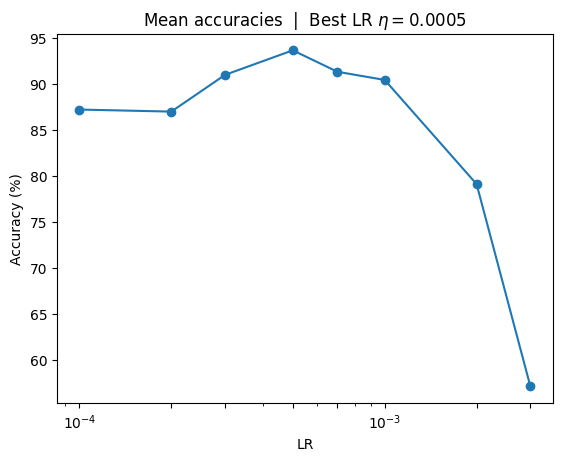

In [115]:
%%time

LRs = [0.003, 0.002, 0.001, 0.0007, 0.0005, 0.0003, 0.0002, 0.0001]
NB_REP = 3

mean_accuracies = []
for LR in LRs:
    print(f'{LR = }')
    accuracies = []
    for _ in range(NB_REP):
        ### HYPERPARAMS ####
        MINI_BATCH_SIZE = 16
        EPOCHS = 10
        # LR = 0.001
        EPS = 20  # Total epsilon for I-FGSM
        ETA = 4  # Step for each iteration
        MAX_ITER_FGSM = 10  # Maximum number of iterations for I-FGSM
        ####################
        
        
        # Get initialized mode
        from core.models import FashionNN
        model = FashionNN()
        model.train()
        
        # Dataloader
        dataset = TensorDataset(images, labels)
        dataloader = DataLoader(dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)
        
        # Optim & loss function
        optimizer = optim.SGD(model.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss()
        
        # Train
        for epoch in range(EPOCHS):
            for i, (normal_inputs, targets) in enumerate(dataloader):
                normal_inputs.requires_grad = True
                adv_inputs = adv(normal_inputs.clone().detach(), 
                    normal_inputs.clone().detach(),
                    optimizer, 
                    model, 
                    loss_fn, 
                    MAX_ITER_FGSM,
                    EPS, 
                    ETA,
                )
                if epoch == 9 and i == 15:
                    model.eval()
                    normal_labels = torch.argmax(model(normal_inputs), 1)
                    adv_labels = torch.argmax(model(adv_inputs), 1)
                    # print(f'{      targets = }')
                    # print(f'{normal_labels = }')
                    # print(f'{   adv_labels = }')
                    model.train()
                for inputs in [normal_inputs, adv_inputs]:
                    optimizer.zero_grad()
                    logits = model(inputs)
                    loss = loss_fn(logits, targets)
                    loss.backward()
                    optimizer.step()
        
        # Predict
        model.eval()
        prediction = torch.argmax(model(images), axis=1)
        accuracies += [int((labels == prediction).sum())/300*100]

    mean_accuracies += [sum(accuracies) / NB_REP]

plt.plot(LRs, mean_accuracies)
plt.scatter(LRs, mean_accuracies)
plt.title(rf'Mean accuracies  |  Best LR $\eta={LRs[np.argmax(np.array(mean_accuracies))]}$')
plt.xlabel('LR')
plt.ylabel('Accuracy (%)')
plt.xscale('log')
_ = plt.xticks(LRs)

### Batch-size tunning

BS = 1
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
norm not exceeded
nor

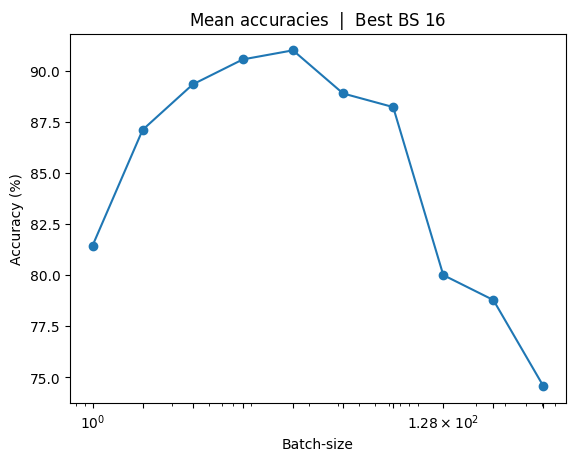

In [117]:
%%time

BSs = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
NB_REP = 3

mean_accuracies = []
for BS in BSs:
    print(f'{BS = }')
    accuracies = []
    for _ in range(NB_REP):
        ### HYPERPARAMS ####
        MINI_BATCH_SIZE = BS
        EPOCHS = 10
        LR = 0.0005
        EPS = 20  # Total epsilon for I-FGSM
        ETA = 4  # Step for each iteration
        MAX_ITER_FGSM = 10  # Maximum number of iterations for I-FGSM
        ####################
        
        
        # Get initialized mode
        from core.models import FashionNN
        model = FashionNN()
        model.train()
        
        # Dataloader
        dataset = TensorDataset(images, labels)
        dataloader = DataLoader(dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)
        
        # Optim & loss function
        optimizer = optim.SGD(model.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss()
        
        # Train
        for epoch in range(EPOCHS):
            for i, (normal_inputs, targets) in enumerate(dataloader):
                normal_inputs.requires_grad = True
                adv_inputs = adv(normal_inputs.clone().detach(), 
                    normal_inputs.clone().detach(),
                    optimizer, 
                    model, 
                    loss_fn, 
                    MAX_ITER_FGSM,
                    EPS, 
                    ETA,
                )
                # if epoch == 9 and i == 15:
                #     model.eval()
                #     normal_labels = torch.argmax(model(normal_inputs), 1)
                #     adv_labels = torch.argmax(model(adv_inputs), 1)
                    # print(f'{      targets = }')
                    # print(f'{normal_labels = }')
                    # print(f'{   adv_labels = }')
                    # model.train()
                for inputs in [normal_inputs, adv_inputs]:
                    optimizer.zero_grad()
                    logits = model(inputs)
                    loss = loss_fn(logits, targets)
                    loss.backward()
                    optimizer.step()
        
        # Predict
        model.eval()
        prediction = torch.argmax(model(images), axis=1)
        accuracies += [int((labels == prediction).sum())/300*100]

    mean_accuracies += [sum(accuracies) / NB_REP]

plt.plot(BSs, mean_accuracies)
plt.scatter(BSs, mean_accuracies)
plt.title(rf'Mean accuracies  |  Best BS ${BSs[np.argmax(np.array(mean_accuracies))]}$')
plt.xlabel('Batch-size')
plt.ylabel('Accuracy (%)')
plt.xscale('log')
_ = plt.xticks(BSs)

## 3. Submission

In [134]:
# Submit with robustness.py

# DO NOT CHANGE THIS IMPORT
# from core.models import FashionNN

def submit(host, model: FashionNN):
    with BytesIO() as stream:
        torch.save(model, stream)
        stream.seek(0)
        data = stream.read()
    url = f"{host}/api/robustness/solve"
    return requests.post(
        url, data=data, headers={"Content-Type": "application/octet-stream"}
    )

# model = FashionNN()
response = submit("http://127.0.0.1:8000", model10).text
print("Your submission key is:", response)
response = submit("http://127.0.0.1:8000", model20).text
print("Your submission key is:", response)
response = submit("http://127.0.0.1:8000", model40).text
print("Your submission key is:", response)

Your submission key is: eyJub25jZSI6ICI4V2k4YTgwZXNpYjZWSGozdytJOWRnPT0iLCAidG9rZW4iOiAiNTRhY3h2RWcvK3p0THpCYnFCbjdzT0NUVVN0QmtFNUxWMXd5ZHJlSVE3Q1lJd2MyeXBZaXBzanhOdVlHY0t2ODBHUmJHTDA0Q3lBbEpjbGdRdXpwekRZMklCOHd3blRFcVFLdExjZWZlb3puK3RhenJlV3pMSDR4cWFZNzZQbVV5bkNkVFFaaXV4Zz0iLCAidGFnIjogImxDNGFONXZNOVhrUjUwVlhCYWxXWHc9PSJ9
Your submission key is: eyJub25jZSI6ICJVdjRBZ2RqOTNIRklhYm04czlJY2RRPT0iLCAidG9rZW4iOiAiSGVwRGVZbDJ3bEJ2Vks0NEdSK01uc0RIRHdJTEFtWG5RNmcyVjFnUFljRkpmZ0pXRmZucnhQc0czUXFhTzdmRTA3TkZYOW1QT0taZDhZSlE5ZUhKb3VCblBCWFNxNDNwOENtN1Vta3VhVEVhbUxEc3I1UUgrYnFjSi93dFRXcmp6Z1Z0ak5vQiIsICJ0YWciOiAidldmeTlMa2N2bUJJWUNDNGJ0d05IUT09In0=
Your submission key is: eyJub25jZSI6ICJJTVZPdS9RbWM5ck5CaGViK1hyOEV3PT0iLCAidG9rZW4iOiAiNHo4SGdITnhHU1U5T0QxRjlwWlh3Tml1RUhFeS9GVWRQbTA0eXVkYWJLb2xRUG1sTUZJWERwa2lnSWpSRC8wUVd2Qzc5OGUzWE9CTXpJUEI5TGI0T2VCTGV6R0pUZ2g5OTZsOEFNVlJXZGgxdDQzalJhaVE2ZVpuUXd4K0p1UU8ySkJOL1I0UiIsICJ0YWciOiAiakF5U2pCZTV2RWNLV1o0ZnRtWlFOZz09In0=


In [ ]:
Your submission key is: eyJub25jZSI6ICJuRGtUeEpBN1N1WnVhTVpKWnp1YlhnPT0iLCAidG9rZW4iOiAid3FqKzlYV2ladVVHQjE5Ull6c1l3MzhPYytIaCsra1pKcGJVQjZ0MDZ3N0IzWWQ3QmxPeEpZVjdwM2JLUTAydndBR29HRFpjeWdlVW9lRUR2WW5WM0xXWi92ZzQ1b3JmcDJFUEtMU3NTdGxwckdvZmRva0JaRmNDcGdSSlRDYTlyU3Vpb040diIsICJ0YWciOiAicUYyRlJWT3lxNXZpbjEyczY2VjYxZz09In0=
Your submission key is: eyJub25jZSI6ICIwUVJLbmMzL3B3U1cxVWduMy9sQWFBPT0iLCAidG9rZW4iOiAiUnZTdTBSWVI3WXdRYkh5TXNCWExjQzYzOXZ5anNyT3ZlOUdncGFaOGtrRUVXbjV4bDl2L2xyY0V5bDR4LzRvdGRwZHlFN3RJWSt6Q3NlQVFJZzdKUDhYR21zcHJYT0JXQWJoUm00YVkreUtnTlh1VXFFV0lwOGI2MXFaektHdEorYnQ0VTVoMiIsICJ0YWciOiAiREF0N0VxNGphMG4vYTdOUUFWSXVCdz09In0=
Your submission key is: eyJub25jZSI6ICI2UjlFUmF6Ry9FQ2pXM3JJV0lRQjdnPT0iLCAidG9rZW4iOiAiM01ma3VzVVFMaFVtTGJQTExQc2JSaDlnVW5FeTNtMHB0S3Qwd1dWZ0plelVvTUlXVWpyTjVFcUxHV011dzVBemtsVFdRNWRwVGE1ODJ4S3ZyT3cvblZIRzdTY2VtMVZvOVJGU3BjQ00xTFdvVDh5WHVhcS93RnQ5ZTlBM3dndkdnWmc0NG9YbyIsICJ0YWciOiAiZUVyVnFDd29TL1U1N0pwZjFMRW40dz09In0=